<div style="text-align: center;">
    <h1>Human Action Recognition within FiftyOne</h1>
    <h2>Model Evaluation</h2>
</div>

---

<div style="text-align: center;">
    <img src="https://github.com/user-attachments/assets/6b1d05e4-3da3-4591-b70f-764e5ad0e5da" alt="fiftyone-logo" width="200">
</div>

---

This notebook walks you through the process of evaluating models for Human Action Recognition. We will use a benchmark dataset available in the Data Zoo of FiftyOne [**UCF101 Dataset**](https://www.crcv.ucf.edu/data/UCF101.php). It covers essential advance steps such as model selection from [Hugging Face](https://docs.voxel51.com/integrations/huggingface.html#basic-usage), loading predictions in the actual FiftyOne Dataset and comparing two models within the [Model Evaluation Panel](https://docs.voxel51.com/user_guide/evaluation.html#model-evaluation-panel-sub-new). All the documentation is in the [FiftyOne](https://docs.voxel51.com/) Docs page.

This Notebook is part of the Notebooks Series of the [Elderly Action Recognition Challenge](https://voxel51.com/computer-vision-events/elderly-action-recognition-challenge-wacv-2025). And it will help you to understand how you can use FiftyOne for model evaluation before you send your submission to the Challenge.

---

**Useful Links:**
- [Challenge Overview](https://voxel51.com/computer-vision-events/elderly-action-recognition-challenge-wacv-2025/)
- [Submission Page](https://eval.ai/web/challenges/challenge-page/2427/overview)

---

**Goal**: Enable participants to work with multiple models and evaluate those, Help them to submit meaningful solutions to the challenge, ultimately advancing the field of action recognition for the elderly.


## Requirements anf FiftyOne Installation

First thing you need to do is create a Python environment in your system, if you are not familiar with that please take a look of this [ReadmeFile](https://github.com/voxel51/fiftyone-examples?tab=readme-ov-file#-prerequisites-for-beginners-), where we will explain how to create the environment. After that be sure you activate the created environment and install FiftyOne there.

In [ ]:
#!pip install fiftyone
#!pip install -U transformers
#!pip install torch

## Imports
In this section, we import all the necessary libraries and modules to work with the dataset, including FiftyOne, pandas, and re for regular expressions. These libraries provide the foundation for loading, processing, and interacting with the dataset.

In [2]:
import os
import fiftyone as fo
import fiftyone.zoo as foz
import fiftyone.utils.video as fouv

## Import the dataset
Now that you have the dataset downloaded and FiftyOne installed, let’s import the dataset into FiftyOne and launch the FiftyOne App. This should take just a few minutes and a few more lines of code

['activitynet-100', 'activitynet-200', 'bdd100k', 'caltech101', 'caltech256', 'cifar10', 'cifar100', 'cityscapes', 'coco-2014', 'coco-2017', 'fashion-mnist', 'fiw', 'hmdb51', 'imagenet-2012', 'imagenet-sample', 'kinetics-400', 'kinetics-600', 'kinetics-700', 'kinetics-700-2020', 'kitti', 'kitti-multiview', 'lfw', 'mnist', 'open-images-v6', 'open-images-v7', 'places', 'quickstart', 'quickstart-3d', 'quickstart-geo', 'quickstart-groups', 'quickstart-video', 'sama-coco', 'ucf101', 'voc-2007', 'voc-2012']
Split 'test' already downloaded
Loading 'ucf101' split 'test'
 100% |█████████████| 11949/11949 [2.4s elapsed, 0s remaining, 5.1K samples/s]      
Dataset 'ucf101-test' created
 100% |█████████████| 11949/11949 [33.7m elapsed, 0s remaining, 7.3 samples/s]      
ucf101-test
Connected to FiftyOne on port 5151 at localhost.
If you are not connecting to a remote session, you may need to start a new session and specify a port



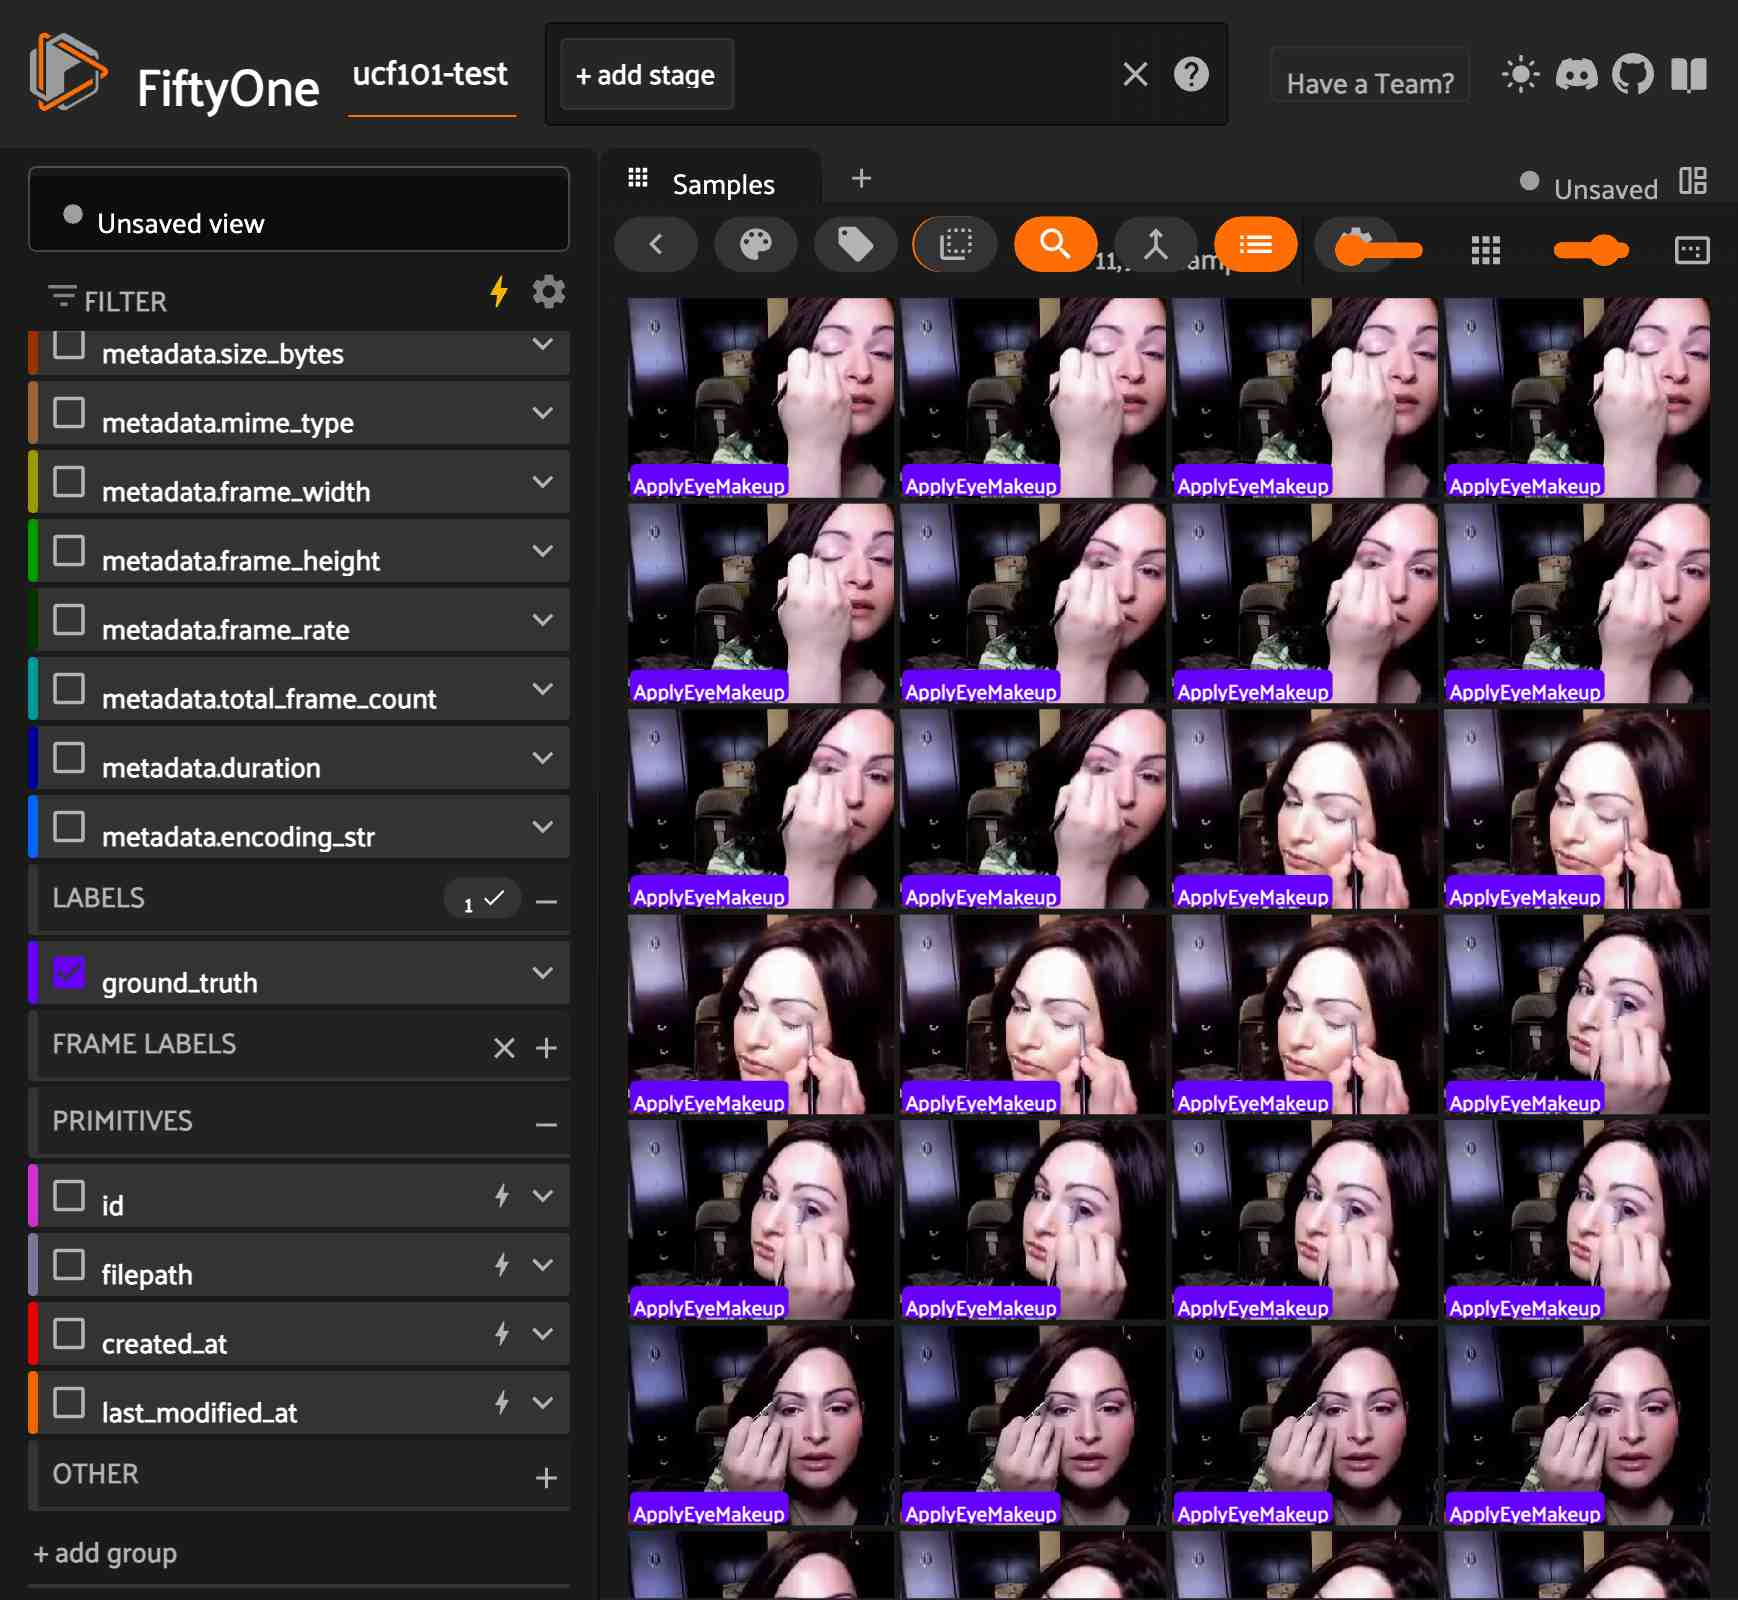

In [5]:
# List available zoo datasets
print(foz.list_zoo_datasets())


dataset = foz.load_zoo_dataset("ucf101", split="test")
# Re-encode source videos as H.264 MP4s so they can be viewed in the App
fouv.reencode_videos(dataset)
print(dataset.name)  # ucf101-test
session = fo.launch_app(dataset)

### Selecting some labels for testing

We are selecting 10 labes in total for the educationa purpose of this notebook. The selected labels are: 

```ApplyEyeMakeup", ApplyLipstick, Archery, BabyCrawling, BalanceBeam, BandMarching, BaseballPitch, Basketball, BasketballDunk, BenchPress```

In [4]:
from fiftyone import ViewField as F

# Only include samples whose ground truth `label` is "slug" or "conch"
selected_view = dataset.filter_labels("ground_truth", (F("label") == "ApplyEyeMakeup") | 
                                      (F("label") == "ApplyLipstick") | (F("label") == "Archery") | 
                                      (F("label") == "BabyCrawling") | (F("label") == "BalanceBeam") | 
                                      (F("label") == "BandMarching") | (F("label") == "BaseballPitch") | 
                                      (F("label") == "Basketball") | (F("label") == "BasketballDunk") | 
                                      (F("label") == "BenchPress"))
new_ucf101_dataset = selected_view.clone()
print(new_ucf101_dataset)

Name:        2025.01.16.16.55.41
Media type:  video
Num samples: 1767
Persistent:  False
Tags:        []
Sample fields:
    id:                fiftyone.core.fields.ObjectIdField
    filepath:          fiftyone.core.fields.StringField
    tags:              fiftyone.core.fields.ListField(fiftyone.core.fields.StringField)
    metadata:          fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.metadata.VideoMetadata)
    created_at:        fiftyone.core.fields.DateTimeField
    last_modified_at:  fiftyone.core.fields.DateTimeField
    ground_truth:      fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.labels.Classification)
    predicted_labels:  fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.labels.Classification)
    predicted_labels2: fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.labels.Classification)
    eval_simple2:      fiftyone.core.fields.BooleanField
    eval_simple:       fiftyone.core.fields.BooleanField
    eval_simple3:      fiftyone.cor

**Tip**: If you want to persist the dataset so you don’t have to repeat the re-encode process when you load it in your next session, add the following to your initial load command:

In [5]:
new_ucf101_dataset.persistent = True

#dataset.persistent = True

#Load the dataset quickly the next session
#import fiftyone as fo
#dataset = fo.load_dataset("ucf101-test")
#session = fo.launch_app(dataset)

## Helper function
In order to create a Video Classification taks we need to ```construct_frames_array``` based-on the sample video.

In [6]:
import cv2
import numpy as np
from PIL import Image
from tqdm.notebook import tqdm

def construct_frames_array(video_path, max_frames=16):
    """
    Extracts up to max_frames from the given video path as PIL.Image objects.

    Args:
        video_path (str): Path to the video file.
        max_frames (int): Maximum number of frames to extract.

    Returns:
        list: A list of NumPy arrays (C, H, W) representing the extracted frames.
    """
    frames = []
    cap = cv2.VideoCapture(video_path)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    frame_rate = max(1, total_frames // max_frames)  # Interval to evenly sample frames

    frame_count = 0
    while len(frames) < max_frames:
        ret, frame = cap.read()
        if not ret:
            break

        # Only extract frames at the specified intervals
        if frame_count % frame_rate == 0:
            # Convert BGR to RGB
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            # Convert to PIL.Image and then to CHW format
            image = Image.fromarray(frame)
            image = np.transpose(np.array(image), (2, 0, 1))
            frames.append(image)

        frame_count += 1

    cap.release()
    return frames

## Hugging Face Model 
FiftyOne integrates natively with Hugging Face’s [Transformers](https://huggingface.co/docs/transformers) library, so you can load, fine-tune, and run inference with your favorite Transformers models on your FiftyOne datasets with just a few lines of code!

We are going to use this model coming from hugging Face: [sayakpaul/videomae-base-finetuned-kinetics-finetuned-ucf101-subset](https://huggingface.co/sayakpaul/videomae-base-finetuned-kinetics-finetuned-ucf101-subset)

Take a look of [Video Classification Examples within Hugging Face](https://github.com/huggingface/notebooks/blob/main/examples/video_classification.ipynb)

In [7]:
from transformers import VideoMAEImageProcessor, VideoMAEForVideoClassification
import torch
from tqdm.notebook import tqdm

processor = VideoMAEImageProcessor.from_pretrained("sayakpaul/videomae-base-finetuned-kinetics-finetuned-ucf101-subset") 
model = VideoMAEForVideoClassification.from_pretrained("sayakpaul/videomae-base-finetuned-kinetics-finetuned-ucf101-subset") 

#frame_fp_lists = dataset.values("filepath")
frame_fp_lists = new_ucf101_dataset.values("filepath")
print(frame_fp_lists)

predicted_labels = []

#fouv.reencode_videos(dataset)  # Ensure videos are H.264 MP4 compatible
#dataset.ensure_frames()  # Extract frames

# Re-encode videos to ensure compatibility
for frame_fps in tqdm(frame_fp_lists):
    video_frames = construct_frames_array(frame_fps, 16)
    inputs = processor(video_frames, return_tensors="pt")

    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits

    # Get predicted class label
    predicted_class_idx = logits.argmax(-1).item()
    predicted_class = model.config.id2label[predicted_class_idx]
    label = fo.Classification(label=predicted_class)
    predicted_labels.append(label)


new_ucf101_dataset.set_values("predicted_labels", predicted_labels)

['/Users/paularamos/fiftyone/ucf101/test/ApplyEyeMakeup/v_ApplyEyeMakeup_g01_c01-original.mp4', '/Users/paularamos/fiftyone/ucf101/test/ApplyEyeMakeup/v_ApplyEyeMakeup_g01_c01-original_34cikg.mp4', '/Users/paularamos/fiftyone/ucf101/test/ApplyEyeMakeup/v_ApplyEyeMakeup_g01_c01-original_zuercd.mp4', '/Users/paularamos/fiftyone/ucf101/test/ApplyEyeMakeup/v_ApplyEyeMakeup_g01_c01.mp4', '/Users/paularamos/fiftyone/ucf101/test/ApplyEyeMakeup/v_ApplyEyeMakeup_g01_c01.mp4', '/Users/paularamos/fiftyone/ucf101/test/ApplyEyeMakeup/v_ApplyEyeMakeup_g01_c02-original.mp4', '/Users/paularamos/fiftyone/ucf101/test/ApplyEyeMakeup/v_ApplyEyeMakeup_g01_c02-original_1u6h6f.mp4', '/Users/paularamos/fiftyone/ucf101/test/ApplyEyeMakeup/v_ApplyEyeMakeup_g01_c02-original_ip0o0w.mp4', '/Users/paularamos/fiftyone/ucf101/test/ApplyEyeMakeup/v_ApplyEyeMakeup_g01_c02.mp4', '/Users/paularamos/fiftyone/ucf101/test/ApplyEyeMakeup/v_ApplyEyeMakeup_g01_c02.mp4', '/Users/paularamos/fiftyone/ucf101/test/ApplyEyeMakeup/v_

  0%|          | 0/1767 [00:00<?, ?it/s]

In [9]:
# Evaluate the predictions in the `predictions` field with respect to the
# labels in the `ground_truth` field
results = new_ucf101_dataset.evaluate_classifications(
    "predicted_labels",
    gt_field="ground_truth",
    eval_key="eval_simple_new1",
)

                precision    recall  f1-score   support

ApplyEyeMakeup       1.00      1.00      1.00       220
 ApplyLipstick       1.00      1.00      1.00       160
       Archery       1.00      1.00      1.00       205
  BabyCrawling       1.00      1.00      1.00       175
   BalanceBeam       1.00      1.00      1.00       155
  BandMarching       1.00      1.00      1.00       215
 BaseballPitch       1.00      1.00      1.00       215
    Basketball       1.00      1.00      1.00       167
BasketballDunk       1.00      1.00      1.00       111
    BenchPress       1.00      1.00      1.00       144

      accuracy                           1.00      1767
     macro avg       1.00      1.00      1.00      1767
  weighted avg       1.00      1.00      1.00      1767



FigureWidget({
    'data': [{'mode': 'markers',
              'opacity': 0.1,
              'type': 'scatter',
              'uid': '3ef758a9-3598-424d-bcd6-1b4c9f0ee3e3',
              'x': array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3,
                          4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6, 7,
                          8, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1,
                          2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5,
                          6, 7, 8, 9]),
              'y': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2,
                          2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4,
                          4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 7, 7,
                          7, 7, 7, 7, 7, 7, 7, 7, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 9, 9, 9, 9, 9, 9,
    


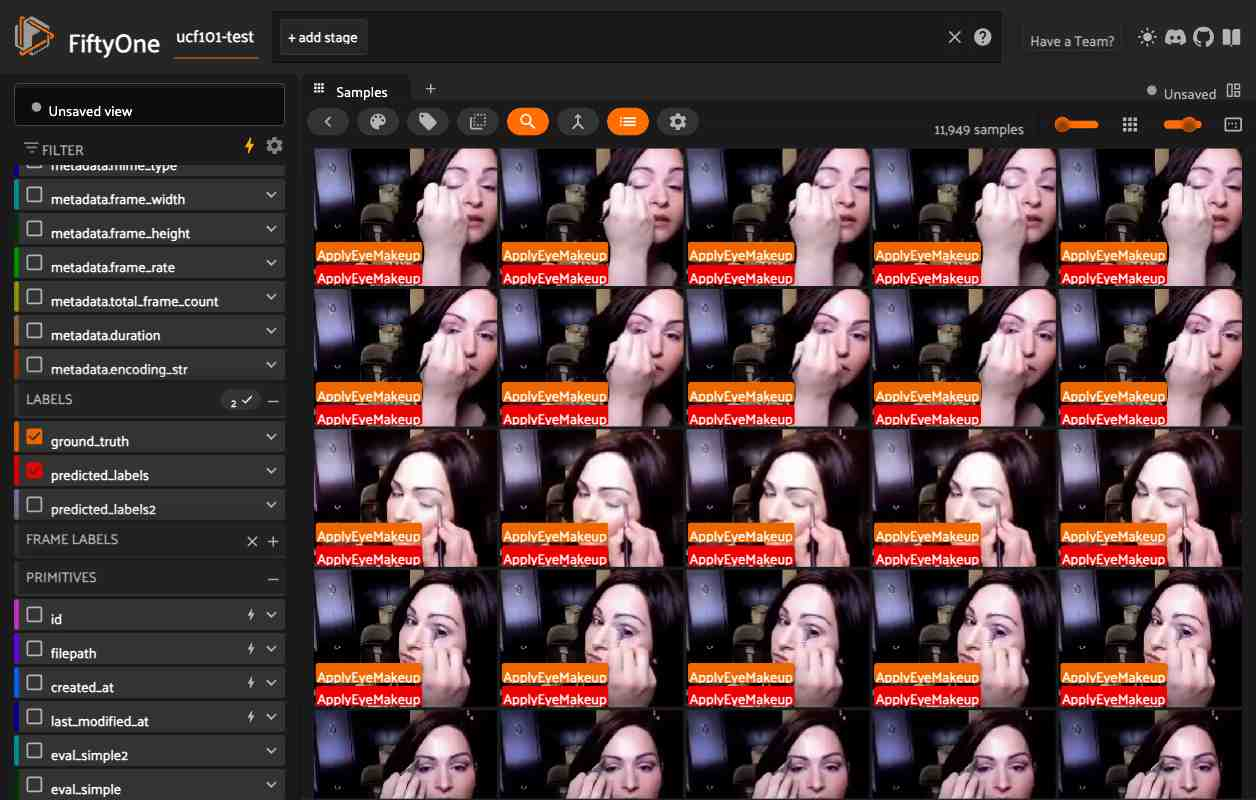

In [10]:
# Print a classification report
results.print_report()

# Plot a confusion matrix
plot = results.plot_confusion_matrix()
plot.show()

# Launch the App to explore
session = fo.launch_app(dataset)

## Interact with the [Model Evaluation Panel](https://docs.voxel51.com/user_guide/evaluation.html#model-evaluation-panel-sub-new)

For showing case purposes, we will modify the ground_truth labels and compare the results using the Model Evaluation Panel.


In [11]:
import random 

classes = new_ucf101_dataset.distinct("ground_truth.label")
print(classes)

def jitter(val):
    if random.random() < 0.10:
        return random.choice(classes)

    return val

predictions = [
    fo.Classification(label=jitter(gt.label), confidence=random.random())
    for gt in new_ucf101_dataset.values("ground_truth")
]

new_ucf101_dataset.set_values("predictions", predictions)

print(new_ucf101_dataset)

['ApplyEyeMakeup', 'ApplyLipstick', 'Archery', 'BabyCrawling', 'BalanceBeam', 'BandMarching', 'BaseballPitch', 'Basketball', 'BasketballDunk', 'BenchPress']
Name:        2025.01.16.16.55.41
Media type:  video
Num samples: 1767
Persistent:  True
Tags:        []
Sample fields:
    id:                fiftyone.core.fields.ObjectIdField
    filepath:          fiftyone.core.fields.StringField
    tags:              fiftyone.core.fields.ListField(fiftyone.core.fields.StringField)
    metadata:          fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.metadata.VideoMetadata)
    created_at:        fiftyone.core.fields.DateTimeField
    last_modified_at:  fiftyone.core.fields.DateTimeField
    ground_truth:      fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.labels.Classification)
    predicted_labels:  fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.labels.Classification)
    predicted_labels2: fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.labels.Classific

In [12]:
# Evaluate the predictions in the `predictions` field with respect to the
# labels in the `ground_truth` field
results2 = new_ucf101_dataset.evaluate_classifications(
    "predictions",
    gt_field="ground_truth",
    eval_key="eval_jitter",
)

# Print a classification report
results2.print_report()

# Plot a confusion matrix
plot = results2.plot_confusion_matrix()
plot.show()

# Launch the App to explore
session = fo.launch_app(new_ucf101_dataset)

                precision    recall  f1-score   support

ApplyEyeMakeup       0.92      0.87      0.90       220
 ApplyLipstick       0.87      0.91      0.89       160
       Archery       0.92      0.92      0.92       205
  BabyCrawling       0.93      0.87      0.90       175
   BalanceBeam       0.87      0.94      0.90       155
  BandMarching       0.93      0.91      0.92       215
 BaseballPitch       0.94      0.91      0.92       215
    Basketball       0.85      0.90      0.88       167
BasketballDunk       0.88      0.89      0.89       111
    BenchPress       0.87      0.89      0.88       144

      accuracy                           0.90      1767
     macro avg       0.90      0.90      0.90      1767
  weighted avg       0.90      0.90      0.90      1767



FigureWidget({
    'data': [{'mode': 'markers',
              'opacity': 0.1,
              'type': 'scatter',
              'uid': 'd032b929-e7d4-492d-8fb8-a120b4b70a1c',
              'x': array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3,
                          4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6, 7,
                          8, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1,
                          2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5,
                          6, 7, 8, 9]),
              'y': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2,
                          2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4,
                          4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 7, 7,
                          7, 7, 7, 7, 7, 7, 7, 7, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 9, 9, 9, 9, 9, 9,
    